In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## A Basic XGB+LGBM Regression Example for Beginners !

### Start here if...

You have some experience with R or Python and machine learning basics. This is a perfect competition for data science students who have completed an online course in machine learning and are looking to expand their skill set before trying a featured competition. 

### Competition Description

![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

if you're complete beginner, then I suggest you to check out the following documentations. It contains a nice intro about boosting algorithms.

- https://xgboost.readthedocs.io/en/latest/
- https://lightgbm.readthedocs.io/en/latest/
- https://www.analyticsvidhya.com/blog/2015/11/quick-introduction-boosting-algorithms-machine-learning/

# Imports

In [45]:
# !pip uninstall pandas-profiling
# !pip install pandas-profiling[notebook,html]

In [46]:
import os
import warnings
import numpy as np 
import pandas as pd 
import pandas_profiling as pp
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Getting the data

In [47]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/Advance House Prediction/train.csv')
test  = pd.read_csv('/content/drive/MyDrive/Datasets/Advance House Prediction/test.csv')
sample= pd.read_csv('/content/drive/MyDrive/Datasets/Advance House Prediction/sample_submission.csv')

# Exploratory Data Analysis

*pandas_profiling -> Generates profile reports from a pandas DataFrame. The pandas df.describe() function is great but a little basic for serious exploratory data analysis. pandas_profiling extends the pandas DataFrame with df.profile_report() for quick data analysis.*

In [48]:
prof = pp.ProfileReport(train, title="Pandas Profiling Report")

In [6]:
prof

Summarize dataset:   0%|          | 0/94 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
prof.to_file('profile_report.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

As the dataset is huge I have saved the EDA html file here .

### Initialising Train and Target

In [49]:
y = train[['Id','SalePrice']]
train = train.drop('SalePrice',axis=1)

### Concatenating Train and Test datasets vertically.

In [50]:
all_dfs = [train,test]
all_df = pd.concat(all_dfs).reset_index(drop=True);

### Displaying Sum of Null Values

In [51]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [52]:
display_all(all_df.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

# Data Preprocessing & Feature Engineering

## Dropping Irrelevant Columns

In [53]:
all_df.drop(['Alley','PoolQC','MiscFeature','Fence','FireplaceQu','Utilities'],axis=1,inplace=True)

## Filling Null values with specific values

In [54]:
all_df['LotFrontage'].fillna(value=all_df['LotFrontage'].median(),inplace=True)
all_df['MasVnrType'].fillna(value='None',inplace=True)
all_df['MasVnrArea'].fillna(0,inplace=True)
all_df['BsmtCond'].fillna(value='TA',inplace=True)
all_df['BsmtExposure'].fillna(value='No',inplace=True)
all_df['Electrical'].fillna(value='SBrkr',inplace=True)
all_df['BsmtFinType2'].fillna(value='Unf',inplace=True)
all_df['GarageType'].fillna(value='Attchd',inplace=True)
all_df['GarageYrBlt'].fillna(value=all_df['GarageYrBlt'].median(),inplace=True)
all_df['GarageFinish'].fillna(value='Unf',inplace=True)
all_df['GarageQual'].fillna(value='TA',inplace=True)
all_df['GarageCond'].fillna(value='TA',inplace=True)
all_df['BsmtFinType1'].fillna(value='NO',inplace=True)
all_df['BsmtQual'].fillna(value='No',inplace=True)
all_df['BsmtFullBath'].fillna(value=all_df['BsmtFullBath'].median(),inplace=True)
all_df['BsmtFinSF1'].fillna(value=all_df['BsmtFinSF1'].median(),inplace=True)
all_df['BsmtFinSF2'].fillna(value=0,inplace=True)
all_df['BsmtUnfSF'].fillna(value=0,inplace=True)
all_df['TotalBsmtSF'].fillna(value=all_df['TotalBsmtSF'].median(),inplace=True)
all_df['BsmtHalfBath'].fillna(value=0,inplace=True)
all_df['GarageCars'].fillna(value=all_df['GarageCars'].median(),inplace=True)
all_df['GarageArea'].fillna(value=all_df['GarageArea'].median(),inplace=True)

## Encoding All Object Datatypes with Label Enconding

*Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.*

In [55]:
labelencoder=LabelEncoder()

all_df['MSZoning']      = labelencoder.fit_transform(all_df['MSZoning'].astype(str))
all_df['Exterior1st']   = labelencoder.fit_transform(all_df['Exterior1st'].astype(str))
all_df['Exterior2nd']   = labelencoder.fit_transform(all_df['Exterior2nd'].astype(str))
all_df['KitchenQual']   = labelencoder.fit_transform(all_df['KitchenQual'].astype(str))
all_df['Functional']    = labelencoder.fit_transform(all_df['Functional'].astype(str))
all_df['SaleType']      = labelencoder.fit_transform(all_df['SaleType'].astype(str))
all_df['Street']        = labelencoder.fit_transform(all_df['Street'])   
all_df['LotShape']      = labelencoder.fit_transform(all_df['LotShape'])   
all_df['LandContour']   = labelencoder.fit_transform(all_df['LandContour'])   
all_df['LotConfig']     = labelencoder.fit_transform(all_df['LotConfig'])   
all_df['LandSlope']     = labelencoder.fit_transform(all_df['LandSlope'])   
all_df['Neighborhood']  = labelencoder.fit_transform(all_df['Neighborhood'])   
all_df['Condition1']    = labelencoder.fit_transform(all_df['Condition1'])   
all_df['Condition2']    = labelencoder.fit_transform(all_df['Condition2'])   
all_df['BldgType']      = labelencoder.fit_transform(all_df['BldgType'])   
all_df['HouseStyle']    = labelencoder.fit_transform(all_df['HouseStyle'])   
all_df['RoofStyle']     = labelencoder.fit_transform(all_df['RoofStyle'])   
all_df['RoofMatl']      = labelencoder.fit_transform(all_df['RoofMatl'])    
all_df['MasVnrType']    = labelencoder.fit_transform(all_df['MasVnrType'])   
all_df['ExterQual']     = labelencoder.fit_transform(all_df['ExterQual'])  
all_df['ExterCond']     = labelencoder.fit_transform(all_df['ExterCond'])   
all_df['Foundation']    = labelencoder.fit_transform(all_df['Foundation'])   
all_df['BsmtQual']      = labelencoder.fit_transform(all_df['BsmtQual'])   
all_df['BsmtCond']      = labelencoder.fit_transform(all_df['BsmtCond'])   
all_df['BsmtExposure']  = labelencoder.fit_transform(all_df['BsmtExposure'])   
all_df['BsmtFinType1']  = labelencoder.fit_transform(all_df['BsmtFinType1'])   
all_df['BsmtFinType2']  = labelencoder.fit_transform(all_df['BsmtFinType2'])   
all_df['Heating']       = labelencoder.fit_transform(all_df['Heating'])   
all_df['HeatingQC']     = labelencoder.fit_transform(all_df['HeatingQC'])   
all_df['CentralAir']    = labelencoder.fit_transform(all_df['CentralAir'])   
all_df['Electrical']    = labelencoder.fit_transform(all_df['Electrical'])    
all_df['GarageType']    = labelencoder.fit_transform(all_df['GarageType'])  
all_df['GarageFinish']  = labelencoder.fit_transform(all_df['GarageFinish'])   
all_df['GarageQual']    = labelencoder.fit_transform(all_df['GarageQual'])  
all_df['GarageCond']    = labelencoder.fit_transform(all_df['GarageCond'])   
all_df['PavedDrive']    = labelencoder.fit_transform(all_df['PavedDrive'])  
all_df['SaleCondition'] = labelencoder.fit_transform(all_df['SaleCondition'])  

## Scaling the dataset to use Linear Models

*Standard Scalar: Standardize features by removing the mean and scaling to unit variance*
*The standard score of a sample x is calculated as:*

    z = (x - u) / s

*where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.*

In [56]:
Scaler = StandardScaler()
all_scaled = pd.DataFrame(Scaler.fit_transform(all_df))

train_scaled = pd.DataFrame(all_scaled[:1460])
test_scaled = pd.DataFrame(all_scaled[1460:2920])

# Modeling

## Train - Test split !

In [57]:
X = train_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y['SalePrice'], test_size=0.1, random_state=42)

## XGBoost

In [58]:
from xgboost import XGBRegressor
XGB = XGBRegressor(max_depth=2,learning_rate=0.1,n_estimators=1000,reg_alpha=0.001,reg_lambda=0.000001,n_jobs=-1,min_child_weight=3)
XGB.fit(X_train,y_train)

[09:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=3, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.001, reg_lambda=1e-06, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## LightGBM

In [59]:
from lightgbm import LGBMRegressor
LGBM = LGBMRegressor(n_estimators = 1000)
LGBM.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Scores of the Models

In [60]:
print ("XGB Training score:",XGB.score(X_train,y_train),"Test Score:",XGB.score(X_test,y_test))
print ("LGBM Training score:",LGBM.score(X_train,y_train),"Test Score:",LGBM.score(X_test,y_test))

XGB Training score: 0.9878463275679412 Test Score: 0.930856175748829
LGBM Training score: 0.9999557727264998 Test Score: 0.9101390980189892


## Mixing 50% + 50% of Both the Models to get an Optimum Model.

In [61]:
y_pred_xgb  = pd.DataFrame( XGB.predict(test_scaled))
y_pred_lgbm = pd.DataFrame(LGBM.predict(test_scaled))

y_pred=pd.DataFrame()
y_pred['SalePrice'] = 0.5 * y_pred_xgb[0] + 0.5 * y_pred_lgbm[0]
y_pred['Id'] = test['Id']

# Submission

In [67]:
y_pred.to_csv('submission.csv',index=False)

## Some Regression Visuals to help us understand the current state!

In [63]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import ValidationCurve

*Residuals Plot*

*Residuals, in the context of regression models, are the difference between the observed value of the target variable (y) and the predicted value (ŷ), i.e. the error of the prediction. The residuals plot shows the difference between residuals on the vertical axis and the dependent variable on the horizontal axis, allowing you to detect regions within the target that may be susceptible to more or less error.*

[09:37:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(alpha=0.75,
              ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f411e9759d0>,
              hist=True, line_color=None, model=None, test_color=None,
              train_color=None)

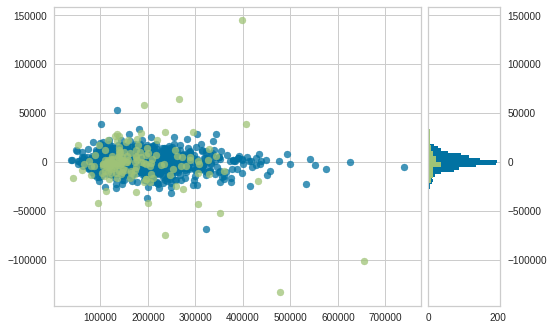

In [64]:
visualizer = ResidualsPlot(XGB)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer

*Prediction Error Plot*

*A prediction error plot shows the actual targets from the dataset against the predicted values generated by our model. This allows us to see how much variance is in the model. Data scientists can diagnose regression models using this plot by comparing against the 45 degree line, where the prediction exactly matches the model.*

0.8495537369561043

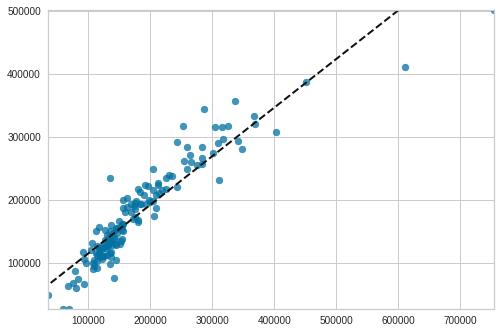

In [65]:
model = Lasso(alpha=10)
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)

You can find additional information of Yellowbricks  through its website: https://www.scikit-yb.org/en/latest/

# Thanks A Lot For Your Time ! Please Upvote if you Like it.

<p align="center">
  <img width="460" height="300" src="https://media.giphy.com/media/CHmwA02GQ6aTS/giphy.gif">
</p>